In [4]:
import os
import pandas as pd
import configparser
import networkx as nx
import matplotlib.pyplot as plt

from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
from rdflib.namespace import DC, FOAF

In [5]:

# ConfigParserのインスタンスを作成
config = configparser.ConfigParser()

# config.iniファイルを読み込む
config.read('../config.ini')

# 指定したセクションとキーから値を取得
cookpad_db_port = config.getint('Data', 'cookpad_db_port')
rakuten_data_path = config.get('Data', 'rakuten_data_path')
nutrition_data_path = config.get('Data', 'nutrition_data_path')

# 値を表示
print(f"Cookpad DB Port: {cookpad_db_port}")
print(f"Rakuten Data Path: {rakuten_data_path}")
print(f"Nutrition Data Path: {nutrition_data_path}")


Cookpad DB Port: 3306
Rakuten Data Path: /mnt/d/data_recipe_rakuten
Nutrition Data Path: /mnt/d/data_nutrient_FoodTableJP


# データ加工部分

In [56]:
input_file_path = os.path.join(nutrition_data_path,"20230428-mxt_kagsei-mext_00001_012_sample.xlsx")
df = pd.read_excel(input_file_path, header=[11])
df = df.rename(columns={"Unnamed: 0":"Food_Group","Unnamed: 1":"Food_Code","Unnamed: 2":"Reference_Number","成分識別子":"Food_Name","Unnamed: 61":"note"})
df = df.dropna(how='all', axis=1)
output_file_path = os.path.join(nutrition_data_path,"20230428-mxt_kagsei-mext_00001_012_sample.csv")
df.to_csv(output_file_path,index=0)

## RDFトリプル作成

In [59]:
data_file_path = os.path.join(nutrition_data_path,"20230428-mxt_kagsei-mext_00001_012_sample.csv")
df = pd.read_csv(data_file_path)

In [60]:
df.head(10)

,Food_Group,Food_Code,Reference_Number,Food_Name,REFUSE,ENERC,ENERC_KCAL,WATER,PROTCAA,PROT-,...,NE,VITB6A,VITB12,FOL,PANTAC,BIOT,VITC,ALC,NACL_EQ,note
0,1,1001,1,アマランサス 玄穀,0,1452,343,13.5,(11.3),12.7,...,(3.8),0.58,(0),130,1.69,16.0,(0),-,0.0,NaN
1,1,1002,2,あわ 精白粒,0,1466,346,13.3,10.2,11.2,...,6.4,0.18,(0),29,1.83,14.0,0,-,0.0,うるち、もちを含む\n歩留り： 70～80 %
2,1,1003,3,あわ あわもち,0,890,210,48.0,(4.5),5.1,...,(1.7),0.03,0,7,0.61,3.4,0,-,0.0,原材料配合割合： もちあわ50、もち米50
3,1,1004,4,えんばく オートミール,0,1479,350,10.0,12.2,13.7,...,4.5,0.11,(0),30,1.29,22.0,(0),-,0.0,別名： オート、オーツ
4,1,1005,5,おおむぎ 七分つき押麦,0,1454,343,14.0,(9.7),10.9,...,(5.8),0.14,(0),17,0.43,-,(0),-,0.0,歩留り： 玄皮麦60～65 %、玄裸麦65～70 %
5,1,1006,6,おおむぎ 押麦 乾,0,1395,329,12.7,5.9,6.7,...,5.0,0.13,(0),10,0.40,2.7,(0),-,0.0,歩留り： 玄皮麦45～55 %、玄裸麦55～65 %\n食物繊維：AOAC2011.25法
6,1,1170,7,おおむぎ 押麦 めし,0,500,118,68.6,2.0,2.2,...,1.3,0.03,(0),3,0.13,0.8,(0),-,0.0,乾35 g相当量を含む\n食物繊維：AOAC2011.25法
7,1,1007,8,おおむぎ 米粒麦,0,1407,333,14.0,(6.2),7.0,...,(4.0),0.19,(0),10,0.64,3.5,(0),-,0.0,別名： 切断麦\n白麦を含む\n歩留り： 玄皮麦40～50 %、玄裸麦50～60 %
8,1,1008,9,おおむぎ 大麦めん 乾,0,1457,343,14.0,(11.7),12.9,...,(6.3),0.09,(0),19,0.64,-,(0),-,2.8,原材料配合割合： 大麦粉 50、小麦粉 50
9,1,1009,10,おおむぎ 大麦めん ゆで,0,516,121,70.0,(4.4),4.8,...,(2.0),0.01,(0),5,0.26,-,(0),-,0.2,原材料配合割合： 大麦粉 50、小麦粉 50


In [61]:
# Redefine the graph
g = Graph()

# Define the namespace
n = Namespace("http://JapaneseFoodKG/food_nutrition")

# Define the graph
g = Graph()

# Loop over the rows in the dataframe
for index, row in df.iterrows():
    # Define the food node
    food = URIRef(f"{n}{row['Food_Name']}")
    
    # Add the food node to the graph
    g.add((food, RDF.type, FOAF.Person))
    
    # Loop over the nutrients in the row
    for col in df.columns[4:]:
        # Define the nutrient node
        nutrient = URIRef(f"{n}{col}")
        
        # Add the nutrient node to the graph
        g.add((nutrient, RDF.type, FOAF.Person))
        
        # Define the edge between the food and the nutrient
        edge = BNode()  # a blank node
        
        # Add the edge to the graph
        g.add((food, n.edge, edge))
        g.add((edge, DC.creator, nutrient))
        g.add((edge, DC.title, Literal(row[col])))

# Serialize the graph in RDF format
g.serialize(destination='knowledge_graph.rdf', format='xml')

http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionVITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionVITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionVITK  does not look like a valid URI, tr

<Graph identifier=Nb1bbe7e6c80f42a1ab557aa2efa4911c (<class 'rdflib.graph.Graph'>)>

http://JapaneseFoodKG/food_nutritionVITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionVITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoodKG/food_nutritionUnnamed: 14 does not look like a valid U

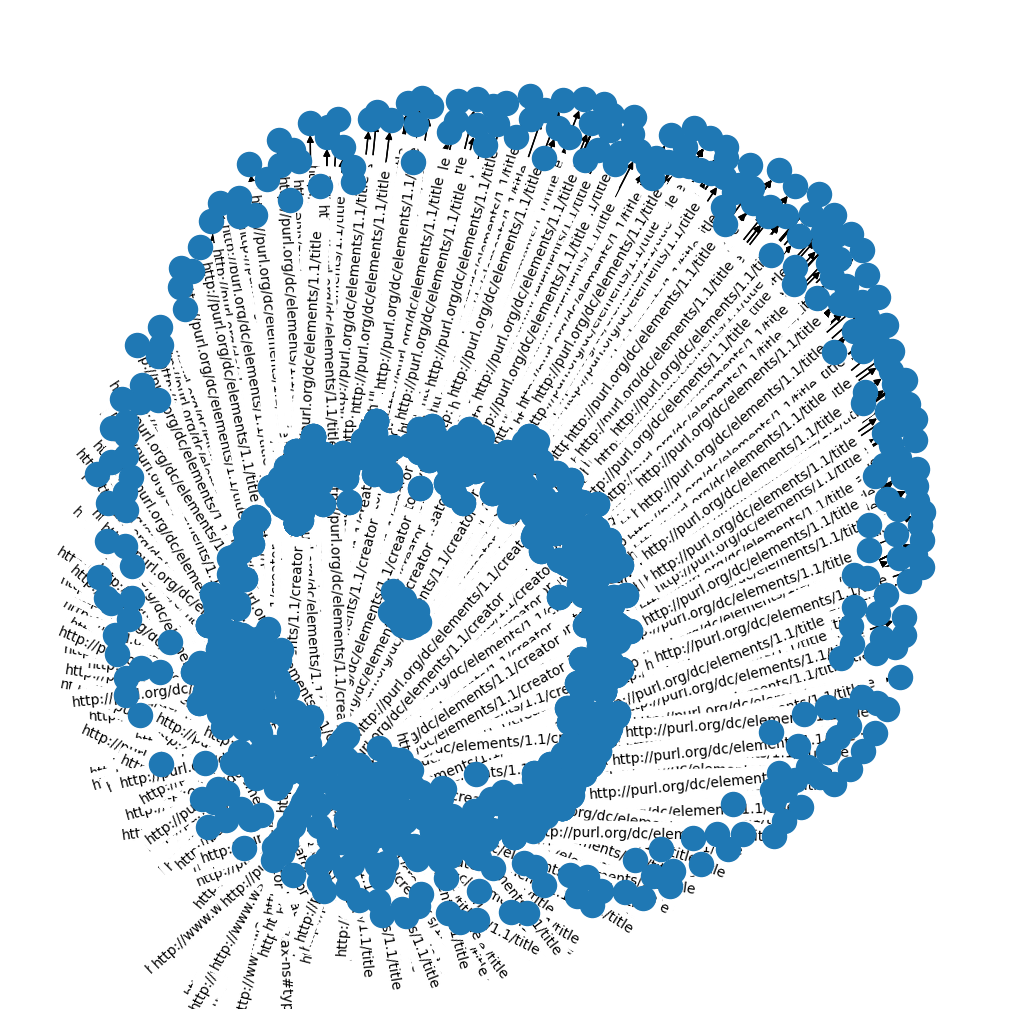

In [69]:

from rdflib import Graph

# Parse the RDF file
g = Graph()
g.parse("knowledge_graph.rdf")

# Get the triples
triples = list(g.triples((None, None, None)))

# Add edges to the graph (subject -> object, with predicate as edge label)
for subj, pred, obj in triples:
    G.add_edge(str(subj), str(obj), label=str(pred))

# Plot the graph
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=False, arrows=True)

# labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [71]:
def format_label(label):
    """Helper function to format the RDF labels."""
    return label.split("/")[-1]

/home/yoshimaru/JapaneseFoodKG/.env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshimaru/JapaneseFoodKG/.env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12416 (\N{HIRAGANA LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshimaru/JapaneseFoodKG/.env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12366 (\N{HIRAGANA LETTER GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshimaru/JapaneseFoodKG/.env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshimaru/JapaneseFoodKG/.env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25276 (\N{CJK UNIFIED IDEOG

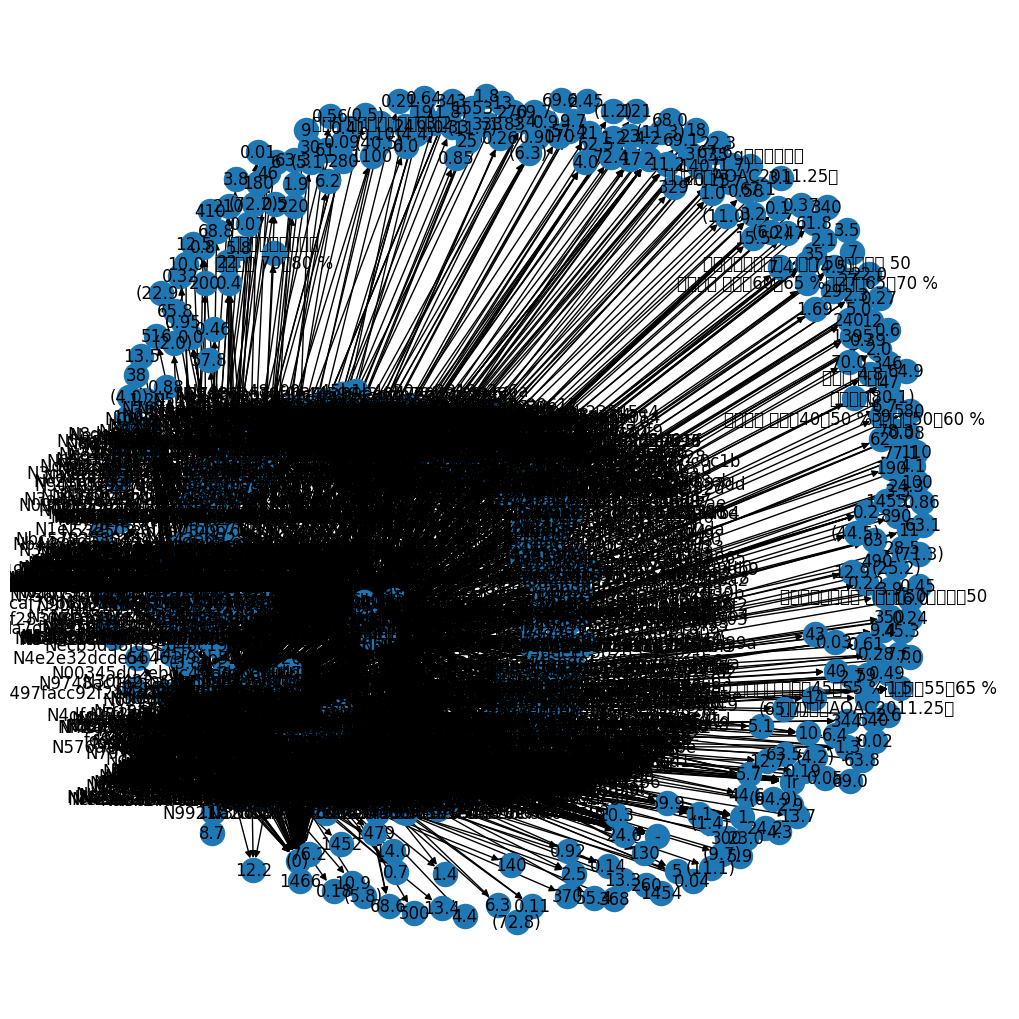

In [72]:
# Create a directed graph
G_nodes_only = nx.DiGraph()

# Add edges to the graph (subject -> object)
for subj, pred, obj in triples:
    G_nodes_only.add_edge(format_label(str(subj)), format_label(str(obj)))

# Plot the graph
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G_nodes_only, seed=42)  # positions for all nodes
nx.draw(G_nodes_only, pos, with_labels=True, arrows=True)

plt.show()


In [6]:
from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
import pandas as pd
import os

# Load the CSV file
data_file_path = os.path.join(nutrition_data_path,"20230428-mxt_kagsei-mext_00001_012_sample.csv")
data = pd.read_csv(data_file_path)

# Create a namespace for our resources
n = Namespace("http://JapaneseFoofKG.org/nutrient/")

# Create a graph
g = Graph()

# Loop through each row in the dataframe
for idx, row in data.iterrows():
    # Create a node for the food
    food = URIRef(n + row['Food_Name'])

    # Loop through each nutrient in the row
    for nutrient in data.columns[4:]:
        # Create a node for the nutrient
        nutrient_node = URIRef(n + nutrient)

        # Add the edge to the graph (food -- nutrient)
        g.add((food, nutrient_node, Literal(row[nutrient])))

# Serialize the graph to a file in RDF format
g.serialize(destination='knowledge_graph.rdf', format='xml')


http://JapaneseFoofKG.org/nutrient/Unnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/Unnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/VITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/Unnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/Unnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/VITK  does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/Unnamed: 14 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/Unnamed: 17 does not look like a valid URI, trying to serialize this will break.
http://JapaneseFoofKG.org/nutrient/VITK  does not look like a valid URI, trying to s

ValueError: "http://JapaneseFoofKG.org/nutrient/VITK " does not look like a valid URI, cannot serialize this. Did you want to urlencode it?